## An analysis of the 210129 ensemble model predictions
How well the model does on different types of grant data, e.g. length of description. So we know where it's predictions are good and where they are bad.

Also looks into how well the model performs when given fortytwo grant text rather than the 360 giving data which is where wellcome-grants-awarded-2005-2019.csv is from.

In [1]:
import re
import ast

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
cd ..

/Users/gallaghe/Code/nutrition-labels


In [3]:
ensemble_date = '210129'

In [4]:
# Extra grants information I got from forty two for the grants in the 210126 training data
extra_grants_info = pd.read_csv('data/processed/fortytwo/tech_grantIDs_210126_training_data_fortytwo_info.csv')

In [5]:
def get_ensemble_grants_info(ensemble_date):
    ensemble_info = f'data/processed/ensemble/{ensemble_date}/{ensemble_date}_training_information_1models.txt'
    ensemble_results_file = f'data/processed/ensemble/{ensemble_date}/{ensemble_date}_all_ensemble_results.csv'
    grant_file = 'data/raw/wellcome-grants-awarded-2005-2019.csv'
    
    # Import the models names and training file name
    with open(ensemble_info, "r") as f:
        for line in f.readlines():
            if 'Ensemble models' in line:
                models = re.sub('Ensemble models: ', '', line)
                models = ast.literal_eval(models)
                
    # Import the ensemble results and which data was used in the test set
    ensemble_data = pd.read_csv(ensemble_results_file)

    # Import the grant data
    grant_data = pd.read_csv(grant_file)
    grant_data.drop_duplicates(['Internal ID'], inplace=True)

    # Merge test data with grant info
    test_results = ensemble_data.loc[ensemble_data['How has this grant been used before?']=='Test data'].reset_index(drop=True)
    test_results = pd.merge(
        test_results,
        grant_data,
        how = 'left',
        on = ['Internal ID']
        )
    
    train_results = ensemble_data.loc[ensemble_data['How has this grant been used before?']=='Training data'].reset_index(drop=True)
    train_results = pd.merge(
        train_results,
        grant_data,
        how = 'left',
        on = ['Internal ID']
        )

    return test_results, train_results

In [9]:
test_results, train_results = get_ensemble_grants_info(ensemble_date)
print(len(test_results))
print(len(train_results))

174
520


In [10]:
extra_cols = ['Cost Centre Division Name', 'Cost Centre Description','Grant ERG Stream','Grant Type Master Grant Type Funding Type',
'Master Grant Type Funding Type','Master Grant Type Name','Reference','Round Account Code Description','Round Application Form Name',
'Round Grant Type Master Grant Type Funding Refresh Group','Round Grant Type Master Grant Type Funding Type',
'Round Grant Type Master Grant Type Name', 'Synopsis', 'Title']
test_results = pd.merge(
        test_results,
        extra_grants_info[extra_cols],
        how = 'left',
        left_on=['Internal ID'],
        right_on=['Reference'],
        )
print(len(test_results))

174


## How well does the model do on

- Recipient Org:Country - UK or not UK
- Financial Year - grouped
- Length of Description + Title
- Cost Centre Division Name
- Master Grant Type Funding Type

In [27]:
test_results['Recipient Org:Country grouped'] = ['UK' if g=='United Kingdom' else 'Not UK' for g in test_results['Recipient Org:Country']]

test_results['Financial Year grouped'] = [
    '<2010' if int(g[0:4])<2010 else (
        '2010-2015' if int(g[0:4])<2015 else (
        '2015-2017' if int(g[0:4])<2017 else '>=2017')
    ) for g in test_results['Financial Year']]

test_results['Description length'] = [len(g) for g in test_results['Description']]
bins = [0,1000, 1250,1500, 2000, 3000, 4000]
test_results['Description length binned'] = pd.cut(test_results['Description length'], bins)

test_results['Synopsis length'] = [len(g) for g in test_results['Synopsis']]
bins = [0,1000, 1250,1500, 2000, 3000, 4000]
test_results['Synopsis length binned'] = pd.cut(test_results['Synopsis length'], bins)

In [28]:
def evaluate_data(data):
    y = data['Relevance code'].tolist()
    y_predict = data['Ensemble predictions - 3 models'].tolist()
    scores = {
            'Sample size': len(data),
            'Proportion actually tech': sum(y)/len(data),
            'accuracy': accuracy_score(y, y_predict),
            'f1': f1_score(y, y_predict, average='binary'),
            'precision_score': precision_score(y, y_predict, zero_division=0, average='binary'),
            'recall_score': recall_score(y, y_predict, zero_division=0, average='binary')}
    return scores

In [29]:
def evaluate_grouped_data(data, group_col):
    all_scores = []
    for group_name in data[group_col].unique():
        group_data = data[data[group_col] == group_name]
        scores = evaluate_data(group_data)
        scores['Group name'] = group_name
        all_scores.append(scores)
    return pd.DataFrame(all_scores).set_index('Group name').round(3)

In [51]:
evaluate_grouped_data(test_results, 'Recipient Org:Country grouped')

,Sample size,Proportion actually tech,accuracy,f1,precision_score,recall_score
Group name,,,,,,
Not UK,17,0.294,0.706,0.286,0.500,0.200
UK,157,0.522,0.879,0.882,0.899,0.866


In [52]:
evaluate_grouped_data(test_results, 'Financial Year grouped')

,Sample size,Proportion actually tech,accuracy,f1,precision_score,recall_score
Group name,,,,,,
>=2017,29,0.414,0.828,0.815,0.733,0.917
2015-2017,40,0.400,0.900,0.882,0.833,0.938
2010-2015,83,0.578,0.855,0.860,0.974,0.771
<2010,22,0.500,0.864,0.857,0.900,0.818


In [53]:
evaluate_grouped_data(test_results, 'Description length binned')

/Users/gallaghe/Code/nutrition-labels/build/virtualenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


,Sample size,Proportion actually tech,accuracy,f1,precision_score,recall_score
Group name,,,,,,
"(1250, 1500]",88,0.489,0.920,0.918,0.929,0.907
"(0, 1000]",16,0.312,0.875,0.833,0.714,1.000
"(1500, 2000]",42,0.524,0.786,0.791,0.810,0.773
"(2000, 3000]",8,0.750,0.750,0.800,1.000,0.667
"(1000, 1250]",19,0.579,0.789,0.778,1.000,0.636
"(3000, 4000]",1,0.000,1.000,0.000,0.000,0.000


In [54]:
n_thresh = 20
length_scores = []
for length in test_results['Description length'].unique():
    length_data = test_results[test_results['Description length'] > length]
    if len(length_data) > n_thresh:
        scores = evaluate_data(length_data)
        scores['Description length minimum'] = length
        length_scores.append(scores)

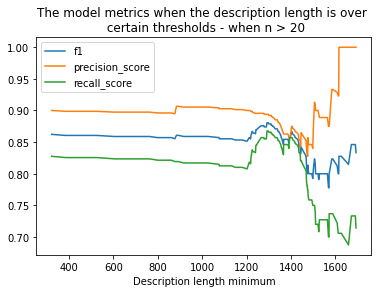

In [55]:
pd.DataFrame(length_scores).sort_values(by='Description length minimum').plot(
    x="Description length minimum",
    y=["f1", "precision_score", "recall_score"],
    title=f'The model metrics when the description length is over \n certain thresholds - when n > {n_thresh}'
);

<AxesSubplot:>

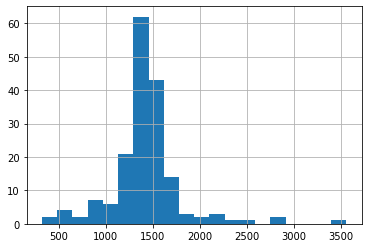

In [56]:
test_results['Description length'].hist(bins=20)

In [57]:
test_results['Description length binned 2'] = pd.cut(test_results['Description length'], [0,1300,4000])
evaluate_grouped_data(test_results, 'Description length binned 2')

,Sample size,Proportion actually tech,accuracy,f1,precision_score,recall_score
Group name,,,,,,
"(1300, 4000]",128,0.523,0.875,0.879,0.892,0.866
"(0, 1300]",46,0.435,0.826,0.778,0.875,0.700


In [33]:
n_thresh = 20
synopsis_length_scores = []
for length in test_results['Synopsis length'].unique():
    length_data = test_results[test_results['Synopsis length'] > length]
    if len(length_data) > n_thresh:
        scores = evaluate_data(length_data)
        scores['Synopsis length minimum'] = length
        synopsis_length_scores.append(scores)

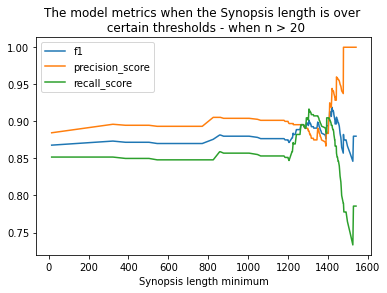

In [34]:
pd.DataFrame(synopsis_length_scores).sort_values(by='Synopsis length minimum').plot(
    x="Synopsis length minimum",
    y=["f1", "precision_score", "recall_score"],
    title=f'The model metrics when the Synopsis length is over \n certain thresholds - when n > {n_thresh}'
);

In [30]:
test_results['Synopsis length binned 2'] = pd.cut(test_results['Synopsis length'], [0,1300,4000])
evaluate_grouped_data(test_results, 'Synopsis length binned 2')

,Sample size,Proportion actually tech,accuracy,f1,precision_score,recall_score
Group name,,,,,,
"(1300, 4000]",113,0.549,0.885,0.896,0.889,0.903
"(0, 1300]",61,0.410,0.820,0.744,0.889,0.640


In [58]:
evaluate_grouped_data(test_results, 'Cost Centre Division Name').sort_values(by='f1', ascending=False)

/Users/gallaghe/Code/nutrition-labels/build/virtualenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


,Sample size,Proportion actually tech,accuracy,f1,precision_score,recall_score
Group name,,,,,,
Science,122,0.631,0.836,0.867,0.89,0.844
Innovations,9,0.556,0.778,0.800,0.80,0.800
Culture & Society,40,0.125,0.950,0.750,1.00,0.600
Directorate,3,0.000,1.000,0.000,0.00,0.000


In [59]:
evaluate_grouped_data(test_results, 'Master Grant Type Funding Type').sort_values(by='f1', ascending=False)

,Sample size,Proportion actually tech,accuracy,f1,precision_score,recall_score
Group name,,,,,,
Seed funding,17,0.059,1.000,1.000,1.000,1.000
AAPs & Centres,3,1.000,1.000,1.000,1.000,1.000
Principal Fellowships,1,1.000,1.000,1.000,1.000,1.000
Collaborative & Project Funding,33,0.636,0.909,0.927,0.950,0.905
Intermediate Fellowships,20,0.500,0.900,0.889,1.000,0.800
Early Career Fellowships,13,0.692,0.846,0.889,0.889,0.889
Equipment & Resources,16,0.625,0.812,0.870,0.769,1.000
Same as its parent,3,1.000,0.667,0.800,1.000,0.667
Senior Fellowships,11,0.727,0.727,0.800,0.857,0.750


In [60]:
evaluate_grouped_data(test_results, 'Round Grant Type Master Grant Type Funding Refresh Group').sort_values(by='f1', ascending=False)

,Sample size,Proportion actually tech,accuracy,f1,precision_score,recall_score
Group name,,,,,,
Seed funding,15,0.067,1.000,1.000,1.000,1.000
Places,3,1.000,1.000,1.000,1.000,1.000
Teams,23,0.565,0.957,0.960,1.000,0.923
Same as its parent,6,0.833,0.833,0.889,1.000,0.800
Resources,15,0.667,0.800,0.870,0.769,1.000
Miscellaneous,27,0.259,0.926,0.833,1.000,0.714
People,84,0.571,0.810,0.822,0.881,0.771
Collaborative,1,0.000,0.000,0.000,0.000,0.000


## How does the model do when predicting on fortytwo description texts?
Since this will be the input for a productionised model we need to make sure that it does ok on this text (rather than just the 360 giving data)

In [102]:
# On test data from 360 giving data, with ['Title', 'Grant Programme:Title', 'Description'] merged and cleaned
test_360_scores = evaluate_data(test_results)
train_360_scores = evaluate_data(train_results)

In [86]:
# I got these by running tech_grant_tagger.py
fortytwo_predictions = pd.read_csv('data/processed/predictions/210204/tech_grantIDs_210126_training_data_fortytwo_info_predictions.csv')

In [99]:
test_results_fortytwo_data = pd.merge(test_results, fortytwo_predictions, how = 'left', 
                                      left_on=['Internal ID'], right_on=['Grant ID'],)
train_results_fortytwo_data = pd.merge(train_results, fortytwo_predictions, how = 'left', 
                                      left_on=['Internal ID'], right_on=['Grant ID'],)

In [104]:
y = test_results_fortytwo_data['Relevance code'].tolist()
y_predict = test_results_fortytwo_data['Tech grant prediction'].tolist()
test_42_scores = {
        'Sample size': len(test_results_fortytwo_data),
        'Proportion actually tech': sum(y)/len(test_results_fortytwo_data),
        'accuracy': accuracy_score(y, y_predict),
        'f1': f1_score(y, y_predict, average='binary'),
        'precision_score': precision_score(y, y_predict, zero_division=0, average='binary'),
        'recall_score': recall_score(y, y_predict, zero_division=0, average='binary')}

In [105]:
y = train_results_fortytwo_data['Relevance code'].tolist()
y_predict = train_results_fortytwo_data['Tech grant prediction'].tolist()
train_42_scores = {
        'Sample size': len(train_results_fortytwo_data),
        'Proportion actually tech': sum(y)/len(train_results_fortytwo_data),
        'accuracy': accuracy_score(y, y_predict),
        'f1': f1_score(y, y_predict, average='binary'),
        'precision_score': precision_score(y, y_predict, zero_division=0, average='binary'),
        'recall_score': recall_score(y, y_predict, zero_division=0, average='binary')}

In [109]:
pd.DataFrame({'Test 360':test_360_scores, 'Test 42':test_42_scores, 'Train 360':train_360_scores, 'Train 42':train_42_scores,}).T


,Sample size,Proportion actually tech,accuracy,f1,precision_score,recall_score
Test 360,174.0,0.5,0.862069,0.857143,0.888889,0.827586
Test 42,174.0,0.5,0.867816,0.867052,0.872093,0.862069
Train 360,520.0,0.5,0.959615,0.957916,1.000000,0.919231
Train 42,520.0,0.5,0.959615,0.958250,0.991770,0.926923
